# Вебинар 6. Консультация по курсовому проекту.

### Задание для курсового проекта

Метрика:
R2 - коэффициент детерминации (sklearn.metrics.r2_score)

Сдача проекта:
1. Прислать в раздел Задания Урока 10 ("Вебинар. Консультация по итоговому проекту")
ссылку на программу в github (программа должна содержаться в файле Jupyter Notebook 
с расширением ipynb). (Pull request не нужен, только ссылка ведущая на сам скрипт).
2. Приложить файл с названием по образцу SShirkin_predictions.csv
с предсказанными ценами для квартир из test.csv (файл должен содержать два поля: Id, Price).
В файле с предсказаниями должна быть 5001 строка (шапка + 5000 предсказаний).

Сроки и условия сдачи:
Дедлайн: сдать проект нужно в течение 72 часов после начала Урока 10 ("Вебинар. Консультация по итоговому проекту").
Для успешной сдачи должны быть все предсказания (для 5000 квартир) и R2 должен быть больше 0.6.
При сдаче до дедлайна результат проекта может попасть в топ лучших результатов.
Повторная сдача и проверка результатов возможны только при условии предыдущей неуспешной сдачи.
Успешный проект нельзя пересдать в целях повышения результата.
Проекты, сданные после дедлайна или сданные повторно, не попадают в топ лучших результатов, но можно узнать результат.
В качестве итогового результата берется первый успешный результат, последующие успешные результаты не учитываются.

Примечание:
Все файлы csv должны содержать названия полей (header - то есть "шапку"),
разделитель - запятая. В файлах не должны содержаться индексы из датафрейма.

Рекомендации для файла с кодом (ipynb):
1. Файл должен содержать заголовки и комментарии
2. Повторяющиеся операции лучше оформлять в виде функций
3. Не делать вывод большого количества строк таблиц (5-10 достаточно)
4. По возможности добавлять графики, описывающие данные (около 3-5)
5. Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
6. Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
7. Весь проект должен быть в одном скрипте (файл ipynb).
8. При использовании статистик (среднее, медиана и т.д.) в качестве признаков,
лучше считать их на трейне, и потом на валидационных и тестовых данных не считать 
статистики заново, а брать их с трейна. Если хватает знаний, можно использовать кросс-валидацию,
но для сдачи этого проекта достаточно разбить данные из train.csv на train и valid.
9. Проект должен полностью отрабатывать за разумное время (не больше 10 минут),
поэтому в финальный вариант лучше не включать GridSearch с перебором 
большого количества сочетаний параметров.
10. Допускается применение библиотек Python и моделей машинного обучения,
которые были в курсе Python для Data Science. Градиентный бустинг изучается
в последующих курсах, поэтому в этом проекте его применять не следует.
Самая сложная из допустимых моделей - RandomForestRegressor из sklearn.

### ToDo

1. Разбить площадь на категории и посчитать цену
2. Посчитать цену на кв. метр
3. Валидационная выборка
4. Перенос признаков на тест

**Подключение библиотек и скриптов**

In [166]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.linear_model import Ridge, Lasso, LinearRegression

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [67]:
import warnings
warnings.filterwarnings('ignore')

In [68]:
matplotlib.rcParams.update({'font.size': 14})

In [69]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

In [80]:
def show_dst(train_df, column):
    plt.figure(figsize = (16, 8))

    train_df[column].hist(bins=18)
    plt.ylabel('Count')
    plt.xlabel(column)

    plt.title('Target distribution')
    plt.show()
    return None

**Пути к директориям и файлам**

In [71]:
TRAIN_DATASET_PATH = 'train.csv'
TEST_DATASET_PATH = 'test.csv'

### Загрузка данных

**Описание датасета**

* **Id** - идентификационный номер квартиры
* **DistrictId** - идентификационный номер района
* **Rooms** - количество комнат
* **Square** - площадь
* **LifeSquare** - жилая площадь
* **KitchenSquare** - площадь кухни
* **Floor** - этаж
* **HouseFloor** - количество этажей в доме
* **HouseYear** - год постройки дома
* **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
* **Social_1, Social_2, Social_3** - социальные показатели местности
* **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья
* **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров
* **Price** - цена квартиры

In [72]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
print(train_df.shape)
train_df.head()

(10000, 20)


,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


In [73]:
train_df.isna().sum()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       2113
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

In [46]:
train_df.head(15)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644
5,12915,59,3.0,80.384479,46.683720,12.0,5,17.0,2011,0.309479,B,B,35,7715,4,990.0,0,6,B,215898.447742
6,14549,154,2.0,62.254114,37.160377,7.0,3,5.0,1960,0.460556,B,B,20,4386,14,NaN,1,5,B,296021.204377
7,11993,74,2.0,80.312926,NaN,0.0,14,0.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B,221244.156664
8,5172,1,2.0,64.511437,NaN,1.0,9,17.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,229102.795999
9,8649,23,1.0,46.461409,18.915552,8.0,13,17.0,2014,0.075779,B,B,6,1437,3,NaN,0,2,B,95380.220993


In [74]:
train_df[train_df['Square'] < train_df['LifeSquare']]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
28,8054,23,1.0,42.530043,43.967759,1.0,3,9.0,2014,0.034656,B,B,0,168,0,NaN,0,0,B,95338.198549
44,10521,38,3.0,104.211396,106.340403,0.0,20,0.0,2017,0.060753,B,B,15,2787,2,520.0,0,7,B,435462.048070
52,2301,1,2.0,61.400054,65.224603,0.0,17,22.0,2016,0.007122,B,B,1,264,0,NaN,0,1,B,199215.452229
123,8753,25,3.0,85.952306,89.803753,1.0,4,3.0,2017,0.069753,B,B,53,13670,4,NaN,1,11,B,309688.592681
153,9870,62,1.0,51.831473,53.491301,1.0,5,1.0,2015,0.072158,B,B,2,629,1,NaN,0,0,A,131797.472284
178,2416,57,1.0,29.298168,29.770784,5.0,7,5.0,1964,0.133215,B,B,49,11395,3,1406.0,3,4,A,148991.265200
184,3398,74,1.0,48.743665,51.011232,1.0,12,20.0,2017,0.075779,B,B,6,1437,3,NaN,0,2,B,165071.825722
212,1748,88,2.0,5.497061,67.628717,1.0,24,22.0,1977,0.127376,B,B,43,8429,3,NaN,3,9,B,412511.088764
217,5540,27,3.0,57.643613,59.425078,9.0,16,10.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,198351.892455
234,12633,27,3.0,81.867166,81.884548,0.0,12,19.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B,182228.520030


In [148]:
def fill_LifeSquare(train_df):
    train_df.loc[(train_df['Square'] < train_df['LifeSquare']) | (train_df['LifeSquare'].isna()), 'LifeSquare'] = \
    (train_df.loc[(train_df['Square'] < train_df['LifeSquare']) | (train_df['LifeSquare'].isna()), 'Square'] - \
    train_df.loc[(train_df['Square'] < train_df['LifeSquare']) | (train_df['LifeSquare'].isna()), 'KitchenSquare'])*0.7
    return train_df

In [82]:
train_df.corr()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
Id,1.000000,0.012973,-0.005847,-0.010071,-0.008822,0.019880,0.001348,-0.008376,0.005004,0.018097,-0.000772,-0.002033,-0.009358,-0.003879,0.001502,-0.008718,0.009880
DistrictId,0.012973,1.000000,0.071432,-0.026613,-0.052857,0.040358,-0.120373,-0.149051,0.013430,0.065294,0.246463,0.167479,0.136095,0.304335,0.306147,0.174214,0.265100
Rooms,-0.005847,0.071432,1.000000,0.662893,0.566211,0.005123,-0.000665,-0.029302,-0.010612,-0.032347,0.075980,0.071335,0.012811,0.042857,0.063557,0.053618,0.550291
Square,-0.010071,-0.026613,0.662893,1.000000,0.857893,0.008320,0.114791,0.081505,-0.009032,-0.064479,-0.070690,-0.043120,0.035241,-0.039748,-0.022960,0.021357,0.520075
LifeSquare,-0.008822,-0.052857,0.566211,0.857893,1.000000,-0.008932,0.085802,0.043059,-0.009027,-0.062469,-0.122460,-0.096665,0.050780,-0.035356,-0.056403,0.005738,0.383647
KitchenSquare,0.019880,0.040358,0.005123,0.008320,-0.008932,1.000000,-0.011397,0.000780,0.000958,-0.005622,0.043379,0.037805,-0.015140,0.009472,0.043170,0.010216,0.028864
Floor,0.001348,-0.120373,-0.000665,0.114791,0.085802,-0.011397,1.000000,0.418986,0.000928,-0.016133,-0.044914,-0.016560,-0.002237,-0.138294,-0.065537,0.024264,0.128715
HouseFloor,-0.008376,-0.149051,-0.029302,0.081505,0.043059,0.000780,0.418986,1.000000,-0.000864,-0.004362,-0.020801,0.007194,-0.008137,-0.143973,-0.068728,0.026279,0.088280
HouseYear,0.005004,0.013430,-0.010612,-0.009032,-0.009027,0.000958,0.000928,-0.000864,1.000000,0.001465,0.003026,0.001970,0.000819,-0.011969,0.011245,0.003681,0.004305
Ecology_1,0.018097,0.065294,-0.032347,-0.064479,-0.062469,-0.005622,-0.016133,-0.004362,0.001465,1.000000,0.026464,0.009264,-0.124068,-0.043547,0.030873,-0.076749,-0.058381


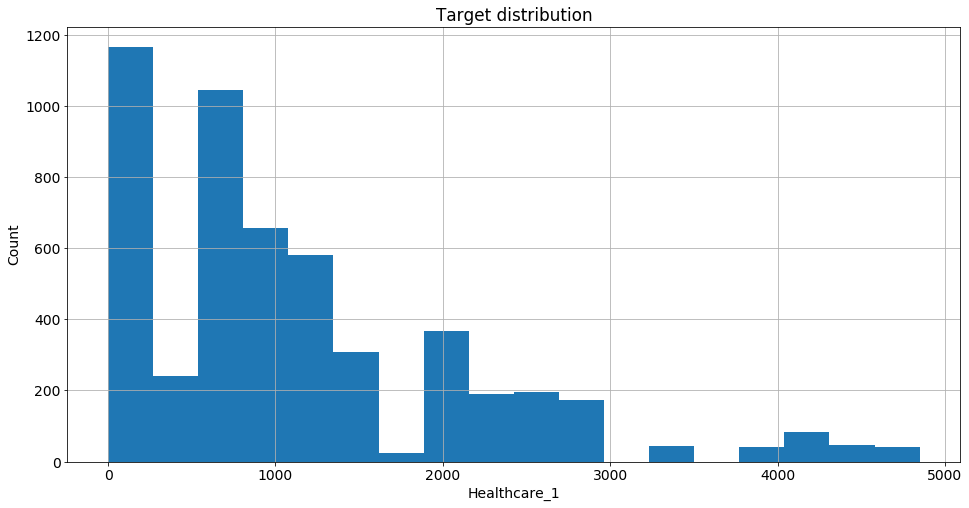

In [81]:
show_dst(train_df,'Healthcare_1') 

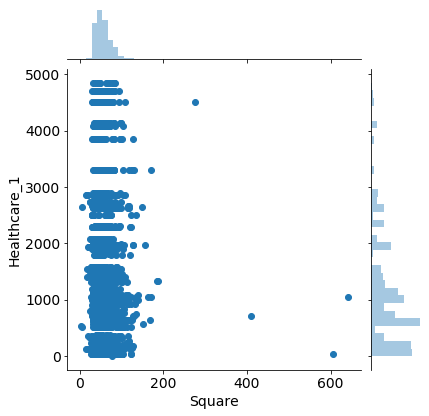

In [83]:
sns.jointplot(train_df['Square'],train_df['Healthcare_1'] )

In [90]:
train_df.drop('Healthcare_1', axis = 'columns', inplace = True)

In [97]:
train_df.isna().sum()

Id               0
DistrictId       0
Rooms            0
Square           0
LifeSquare       0
KitchenSquare    0
Floor            0
HouseFloor       0
HouseYear        0
Ecology_1        0
Ecology_2        0
Ecology_3        0
Social_1         0
Social_2         0
Social_3         0
Helthcare_2      0
Shops_1          0
Shops_2          0
Price            0
dtype: int64

In [96]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 19 columns):
Id               10000 non-null int64
DistrictId       10000 non-null int64
Rooms            10000 non-null float64
Square           10000 non-null float64
LifeSquare       10000 non-null float64
KitchenSquare    10000 non-null float64
Floor            10000 non-null int64
HouseFloor       10000 non-null float64
HouseYear        10000 non-null int64
Ecology_1        10000 non-null float64
Ecology_2        10000 non-null object
Ecology_3        10000 non-null object
Social_1         10000 non-null int64
Social_2         10000 non-null int64
Social_3         10000 non-null int64
Helthcare_2      10000 non-null int64
Shops_1          10000 non-null int64
Shops_2          10000 non-null object
Price            10000 non-null float64
dtypes: float64(7), int64(9), object(3)
memory usage: 1.4+ MB


In [109]:
# Аккуратно проверьте типы данные в исходном train_df перед get_dummies
transform_d_train = pd.get_dummies(train_df)
transform_d_train.columns

Index(['Id', 'DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare',
       'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Social_1', 'Social_2',
       'Social_3', 'Helthcare_2', 'Shops_1', 'Price', 'Ecology_2_A',
       'Ecology_2_B', 'Ecology_3_A', 'Ecology_3_B', 'Shops_2_A', 'Shops_2_B'],
      dtype='object')

In [110]:
features = transform_d_train.drop('Price', axis = 'columns').columns.tolist()
target = ['Price']

In [112]:
X_train, X_valid,y_train, y_valid = train_test_split(transform_d_train[features], transform_d_train[target], test_size = 0.3, random_state = 20)

In [113]:
model = RandomForestRegressor(max_depth=6, n_estimators=300, random_state=20)
model.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=6,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=1,
           oob_score=False, random_state=20, verbose=0, warm_start=False)

In [123]:
predict_price = model.predict(X_valid)


In [124]:
r2(y_valid.values.flatten(), predict_price)

0.6168575666594565

In [143]:
arr_r2_test = []
arr_r2_train = []

max_depth_ = [4,5,6,7,8,9,10,11]
for max_depth in max_depth_:
    model1 = RandomForestRegressor(max_depth=max_depth, n_estimators=60, random_state=20)
    model1.fit(X_train,y_train)
    model2 = Ridge()
    predict_price = model1.predict(X_valid)
    arr_r2_test.append(r2(y_valid.values.flatten(), predict_price))
    predict_price_train = model1.predict(X_train)
    arr_r2_train.append(r2(y_train.values.flatten(), predict_price_train))

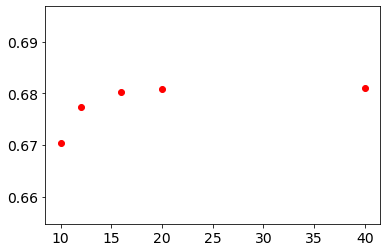

In [138]:
#Рандом форест
plt.scatter(max_depth_, arr_r2_test, c = 'r')
#plt.scatter(max_depth_, arr_r2_train, c = 'b')

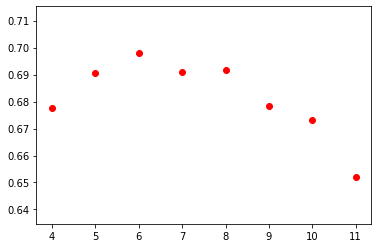

In [144]:
#GradientBoostingRegressor
plt.scatter(max_depth_, arr_r2_test, c = 'r')
#plt.scatter(max_depth_, arr_r2_train, c = 'b')

## Работа с тестовыми данными

In [145]:
test_df = pd.read_csv(TEST_DATASET_PATH)

In [147]:
c.isna().sum()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       1041
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     2377
Helthcare_2         0
Shops_1             0
Shops_2             0
dtype: int64

In [150]:
test_df = fill_LifeSquare(test_df)
test_df.isna().sum()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare          0
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     2377
Helthcare_2         0
Shops_1             0
Shops_2             0
dtype: int64

In [152]:
test_df = test_df.drop('Healthcare_1', axis = 1)

In [154]:
tranform_test_df = pd.get_dummies(test_df)
tranform_test_df.shape

(5000, 21)

In [167]:
model = RandomForestRegressor(max_depth=7, n_estimators=200)
model.fit(transform_d_train[features], transform_d_train[target])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=7,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [169]:
predict_test_price_2 = model.predict(tranform_test_df[features])

In [171]:
cmp_price = pd.DataFrame()
cmp_price['predict7000'] = predict_test_price
cmp_price['predict10000'] = predict_test_price_2


In [159]:
tranform_test_df['predict_price'] = predict_test_price

In [164]:
tranform_test_df[['Id', 'predict_price']].to_csv('base_predict_test.csv', index = False)